In [1]:
%run ../nn_option_pricer/key_imports.py
import sys
sys.path.append("../")
from nn_option_pricer.bs import gbm_step, jax_bs_call

In [124]:
""" 
Fix Random Seed
"""
SEED = 42
rng = default_rng(SEED)

"""
Fix Terminal maturity
"""

T = 1
N_TIMES = 30
N_SAMPLES = 2048
dt = T / N_TIMES
ts = np.linspace(0, T, N_TIMES + 1)

"""
Define State Variables
"""
SKs = rng.uniform(np.log(0.5), np.log(2), N_SAMPLES) # log-moneyness
sigma = rng.uniform(1e-6, 1, N_SAMPLES) # volatilty
barrier_levels = (SKs + rng.uniform(0, 0.5, N_SAMPLES)).reshape((-1, 1)) # barrier


"""
Define Brownian Increments
"""
W = rng.standard_normal((N_SAMPLES, N_TIMES)) * np.sqrt(dt)

"""
Simulate St paths
"""
Sts = np.zeros((N_SAMPLES, N_TIMES + 1))
Sts[:, 0] = SKs
deltas = np.zeros((N_SAMPLES, N_TIMES + 1))
barrier_grad = np.zeros((N_SAMPLES, N_TIMES + 1))


hit_barrier = np.zeros((N_SAMPLES, N_TIMES + 1))

for i in range(N_TIMES):
    Sts[:,i + 1] = gbm_step(Sts[:,i], dt, sigma, W[:,i])
    
barrier_func = lambda x, barrier: 0.5 * (jnp.sign(jnp.exp(x) - jnp.exp(barrier)) + 1)
hit_barrier = jnp.sign(barrier_func(Sts, barrier_levels)[:, ::-1].cumsum(axis = 1)[:, ::-1])
call_payoff = lambda x: jnp.maximum(jnp.exp(x) - 1.0, 0)

for i in range(N_TIMES):
    vec_fun = lambda x, dt, sigma, w: grad(gbm_step, argnums = 0)(x, dt, sigma, w)
    deltas[:, i] = jnp.vectorize(vec_fun)(Sts[:,i], dt, sigma, W[:,i]) * hit_barrier[:,i]
    
deltas *= jnp.vectorize(grad(call_payoff))(Sts[:, [-1]])

ys = call_payoff(Sts[:,[-1]]) * hit_barrier

In [125]:
"""
Combine to create dataset
"""

feat_names = ['log(S/K)', 'ttm', 'b']
f_to_i = lambda x: feat_names.index(x)

Xs = np.vstack([Sts[:, :-1].reshape(-1),
                (sigma.reshape((-1, 1)) * np.sqrt(T - ts))[:,:-1].reshape(-1),
                np.repeat(barrier_levels, N_TIMES)
                ]).T
Xs = Xs.astype(np.float32)
ys = ys[:, :-1].reshape(-1)
print(Xs.shape, ys.shape)
assert Xs.shape[0] == ys.shape[0]

"""
Writeout to csv
"""
X_df = pd.DataFrame(Xs, columns = feat_names)
X_df['pathwise_delta'] = deltas[:,:-1].reshape(-1)
X_df['sigma'] = (sigma.reshape((-1, 1)) * np.sign(T - ts[:-1] + 1)).reshape(-1)
X_df['remaining_timesteps'] = np.repeat(N_TIMES - np.linspace(0, N_TIMES - 1, N_TIMES), N_SAMPLES).reshape((N_TIMES, -1)).T.reshape(-1)
X_df['remaining_timesteps'] = X_df['remaining_timesteps'].astype(int)
X_df['barrier_call_payoff'] = ys
X_df['BS_call'] = jax_bs_call(X_df['log(S/K)'].values, X_df['ttm'].values)
X_df['path'] = X_df.index // (N_TIMES)
X_df.to_csv("datasets/bs_barrier.csv", index=False)
display(X_df)

(61440, 3) (61440,)


,log(S/K),ttm,b,pathwise_delta,sigma,remaining_timesteps,barrier_call_payoff,BS_call,path
0,0.379784,0.146744,0.675323,0.0,0.146744,30,0.0,0.462238,0
1,0.342378,0.144278,0.675323,0.0,0.146744,29,0.0,0.408797,0
2,0.348051,0.141768,0.675323,0.0,0.146744,28,0.0,0.416692,0
3,0.346263,0.139214,0.675323,0.0,0.146744,27,0.0,0.414118,0
4,0.369053,0.136611,0.675323,0.0,0.146744,26,0.0,0.446537,0
...,...,...,...,...,...,...,...,...,...
61435,-0.048681,0.131949,0.385225,0.0,0.323208,5,0.0,0.031045,2047
61436,0.010230,0.118019,0.385225,0.0,0.323208,4,0.0,0.052616,2047
61437,0.003911,0.102207,0.385225,0.0,0.323208,3,0.0,0.042826,2047
61438,0.033567,0.083452,0.385225,0.0,0.323208,2,0.0,0.053619,2047


In [148]:
N_BROWNIANS = 10 ** 5
W = rng.standard_normal((N_BROWNIANS, N_TIMES)) * np.sqrt(dt)
MC_Prices = np.zeros(X_df.shape[0])
for i in tqdm(range(X_df.shape[0])):
    path = (X_df['log(S/K)'].iloc[i] - 0.5 * X_df['ttm'].iloc[i] ** 2) +  np.cumsum(X_df['sigma'].iloc[i] * np.sqrt(dt) * W[:, :int(X_df['remaining_timesteps'].iloc[i])], axis = 1)
    
    MC_Prices[i] = np.mean((path > X_df['b'].iloc[i]).any(axis = 1) * np.maximum(np.exp(path[:,-1]) - 1.0, 0))



# 
# 

  0%|          | 0/61440 [00:00<?, ?it/s]

$$f(a, b) = \sqrt{\frac{2}{\pi}}\frac{(2a - b)}{T^{3/2}}e^{-(2a - b)^{2}/2T}, a > Max(b, 0)$$

$$log(F_{T}/K) - \frac{\sigma^{2}T}{2} + \sigma (W_{T} - W_{t}) > b = W_{T} - W_{t} > \frac{-((\log(F_{t} / K) /b) - \sigma^{2}T/2}{\sigma} = X$$

$$\int_{-\infty}^{\infty} \int_{ \max \{ b, X \} }^{\infty} (F/K e^{-\sigma^{2}T/2} e^{\sigma b} - 1)^{+} f(a, b) da db $$

$$\int_{-\infty}^{\infty} \int_{b }^{\infty} (F/K e^{-\sigma^{2}T/2} e^{\sigma b} - 1)^{+} - \frac{1}{\sqrt{2\pi T}}\exp(-(2a - b)^{2}/2T)  da db $$

$$\int_{-\infty}^{\infty}  (F/K e^{-\sigma^{2}T/2} e^{\sigma b} - 1)^{+} \frac{1}{\sqrt{2\pi T}}\exp(-(2(\max \{ b, X \}) - b)^{2}/2T) db $$

$$\int_{-\infty}^{X}  (F/K e^{-\sigma^{2}T/2} e^{\sigma b} - 1)^{+} \frac{1}{\sqrt{2\pi T}}\exp(-(2X - b)^{2}/2T) db + \int_{X}^{\infty}  (F/K e^{-\sigma^{2}T/2} e^{\sigma b} - 1)^{+} \frac{1}{\sqrt{2\pi T}}\exp(-b^{2}/2T) db$$


$a$ is the running maximum, $b$ is the value of the Brownian



In [151]:
X_df['MC_barrier_call'] = MC_Prices

<AxesSubplot:xlabel='MC_barrier_call'>

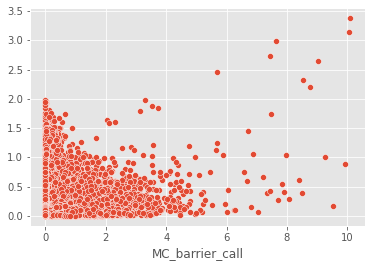

In [152]:
sns.scatterplot(X_df['MC_barrier_call'], X_df['BS_call'] - X_df['MC_barrier_call'])

<AxesSubplot:xlabel='log(S/K)', ylabel='MC_barrier_call'>

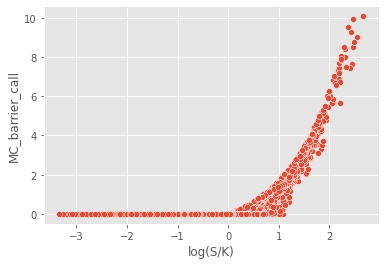

In [157]:
sns.scatterplot(X_df['log(S/K)'], X_df['MC_barrier_call'])

In [158]:
X_df.to_csv("datasets/bs_barrier.csv", index=False)

In [553]:
PDE_prices = []

N_SPACE = 65
S_grid = np.linspace(-1, 3, N_SPACE)
N_TIMES = 10 ** 5
t_grid = np.linspace(0, T, N_TIMES + 1)

dx = (3 - -1) / (N_SPACE - 1)
dt = np.diff(t_grid)[0]

grid = np.zeros((N_SPACE, N_TIMES + 1))
dt / (dx ** 2), dx, dt, b, X_df['log(S/K)'].iloc[0], sigma

(0.00256, 0.0625, 1e-05, -0.06183638051152229, 0.37978372, 0.9780457677422342)

In [544]:
paths = X_df.groupby('path').mean()
PDE_prices = []

In [557]:
temp[['ttm','log(S/K)']].apply(lambda x: spline(x[0], x[1])), axis =1)

210    0.014619
211    0.009253
212    0.012435
213    0.104407
214    0.261360
215    0.303625
216    0.440441
217    0.384397
218    0.380497
219    0.284754
220    0.411813
221    0.312403
222    0.526475
223    0.469196
224    0.466320
225    0.577097
226    0.572175
227    0.518531
228    0.507270
229    0.635486
230    0.526578
231    0.502302
232    0.497375
233    0.612477
234    0.589455
235    0.873283
236    0.832753
237    0.780462
238    0.741673
239    0.542327
dtype: float64

In [564]:
for j in tqdm(range(paths.shape[0])):
    b = paths.iloc[j]['b']
    sigma = paths.iloc[j]['sigma']
    
    ramp = 0
    idx = np.min(np.argwhere(S_grid > (b + ramp)))
    grid[:,-1] = np.maximum((np.exp(S_grid) - 1.0), 0) * (S_grid >= S_grid[idx]) + (S_grid >= b) * (S_grid < S_grid[idx]) * np.maximum((np.exp(S_grid[idx]) - 1.0), 0) / (S_grid[idx] - b) * (S_grid - b)

    for i in range(N_TIMES - 1, -1, -1):
        grid[1:-1, i] = grid[1:-1, i + 1] + dt * (
                       - 0.5 * (sigma ** 2)  * (grid[2:, i + 1] - grid[0:-2, i + 1]) / dx
                       + 0.5 * sigma ** 2 * (grid[0:-2, i + 1] - 2 * grid[1:-1, i + 1] +  grid[2:, i + 1]) / (dx ** 2)
                        )
        grid[-1, i] = np.exp(S_grid[-1]) - 1.0


    
    spline = interp2d(t_grid, S_grid, grid, kind='cubic', copy=False)
    temp = X_df.loc[X_df['path'] == j, ['log(S/K)', 'ttm','sigma']].copy()
    temp['ttm'] = (temp['ttm'] / temp['sigma']) ** 2
    PDE_prices += list(temp[['ttm','log(S/K)']].apply(lambda x: spline(x[0], x[1])[0], axis =1).values)

  0%|          | 0/2048 [00:00<?, ?it/s]

In [570]:
X_df['PDE_call_barrier'] = PDE_prices
X_df.to_csv("datasets/bs_barrier.csv", index=False)

In [7]:
import pandas as pd
import seaborn as sns
sns.set();
X_df = pd.read_csv("datasets/bs_barrier.csv")

<AxesSubplot:xlabel='log(S/K)', ylabel='PDE_call_barrier'>

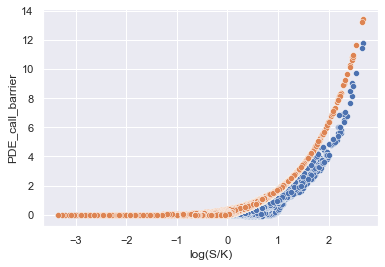

In [9]:
sns.scatterplot(x = X_df['log(S/K)'], y = X_df['PDE_call_barrier'])
sns.scatterplot(x = X_df['log(S/K)'], y = X_df['BS_call'])

<AxesSubplot:xlabel='log(S/K)', ylabel='PDE_call_barrier'>

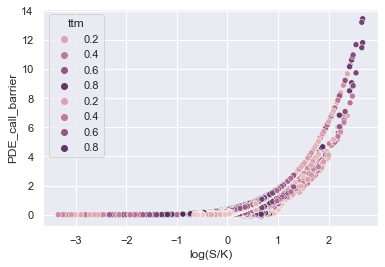

In [12]:
sns.scatterplot(x = X_df['log(S/K)'], y = X_df['PDE_call_barrier'], hue = X_df['ttm'])
sns.scatterplot(x = X_df['log(S/K)'], y = X_df['BS_call'], hue = X_df['ttm'])

<AxesSubplot:xlabel='ttm', ylabel='PDE_call_barrier'>

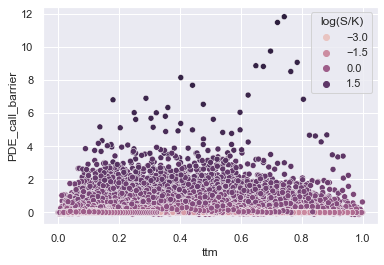

In [14]:
sns.scatterplot(x = X_df['ttm'], y = X_df['PDE_call_barrier'], hue = X_df['log(S/K)'])
# sns.scatterplot(x = X_df['ttm'], y = X_df['BS_call'], hue = X_df['log(S/K)'])

<AxesSubplot:xlabel='log(S/K)', ylabel='PDE_call_barrier'>

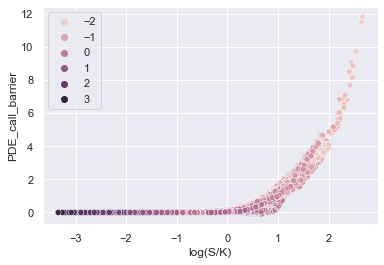

In [16]:
sns.scatterplot(x = X_df['log(S/K)'], y = X_df['PDE_call_barrier'], hue = X_df['b'] - X_df['log(S/K)'])